# Árboles de decisión

En este notebook estudiaremos cómo crear y visualizar árboles de decisión en scikit-learn. 

In [1]:
RANDOM_STATE=83

## Conjunto de datos

En este notebook vamos a usar el conjunto de datos sobre flores del Iris.

In [2]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

# Cargamos el dataset del iris
iris = load_iris()
iris.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])

In [3]:
iris['feature_names']

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

In [4]:
import pandas as pd

df = pd.DataFrame(data=iris['data'], columns=iris['feature_names']) 
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [5]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
sepal length (cm),150.0,5.843333,0.828066,4.3,5.1,5.80,6.4,7.9
sepal width (cm),150.0,3.057333,0.435866,2.0,2.8,3.00,3.3,4.4
petal length (cm),150.0,3.758000,1.765298,1.0,1.6,4.35,5.1,6.9
petal width (cm),150.0,1.199333,0.762238,0.1,0.3,1.30,1.8,2.5


## Dibujar el árbol de decisión

Vamos a construir un árbol de decisión usando los parámetros por defecto y a dibujarlo para analizar cuales son las variables más importantes (las que mejor discriminan).

In [6]:
# Creamos un árbol de decisión con la configuración por defecto y lo entrenamos
clf = DecisionTreeClassifier(random_state=RANDOM_STATE)
clf = clf.fit(iris['data'], iris['target'])

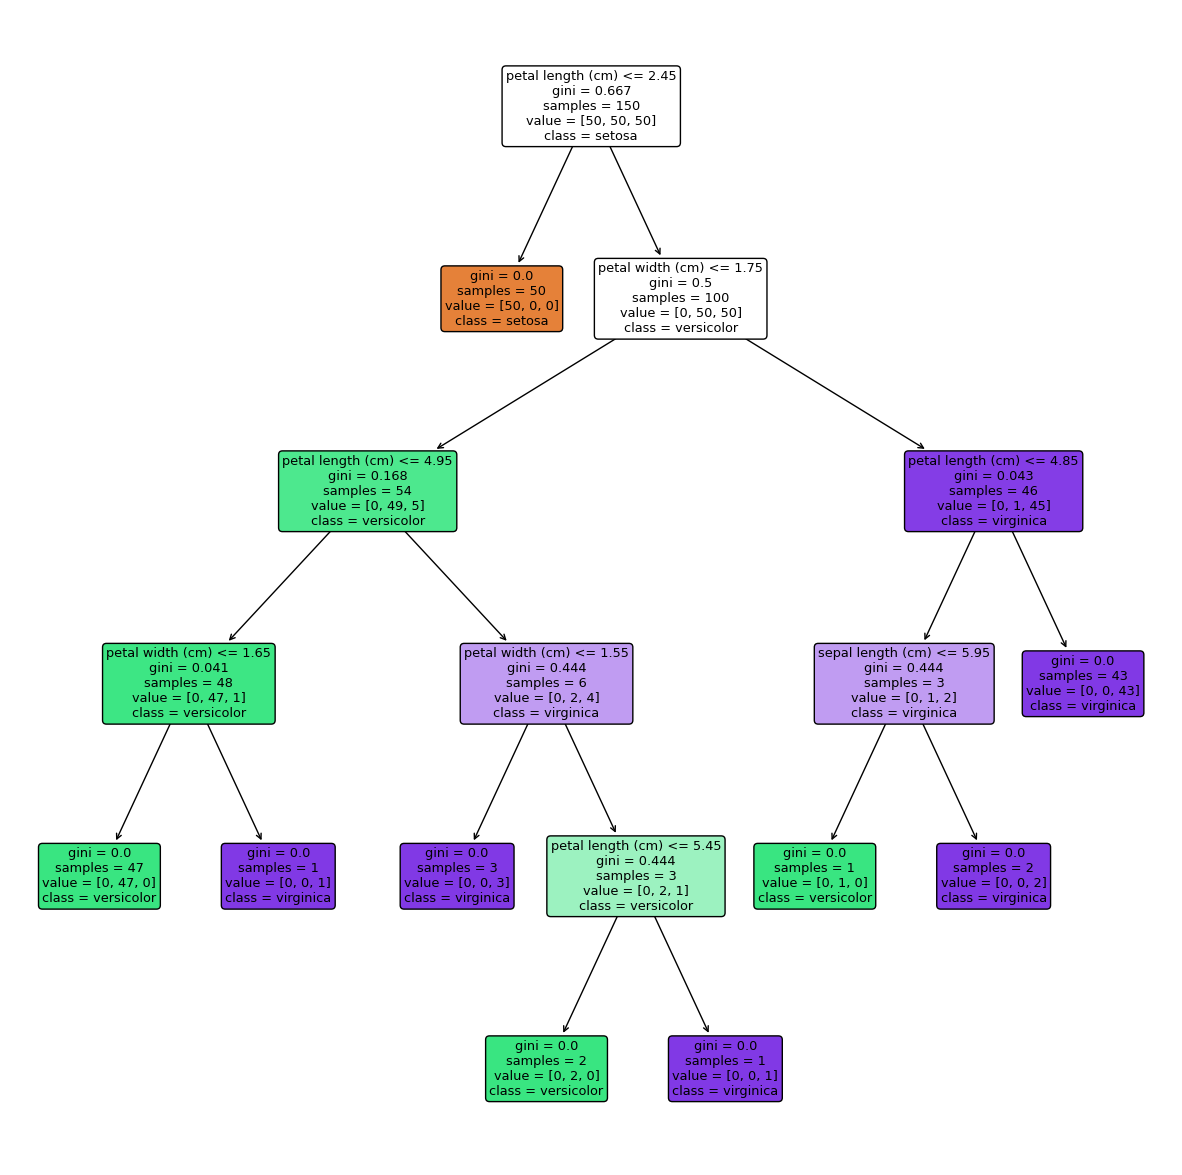

In [7]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Pintamos el árbol
plt.figure(figsize=(15,15))
plot_tree(clf, filled=True, feature_names=iris['feature_names'], class_names=iris['target_names'], rounded=True)
plt.show()

El algortimo que se usa para construir el árbol hace que los primeros niveles del árbol contengan las variables que mejor discriminan las clases que estamos tratando de modelar. En este caso serían "petal length (cm)" y "petal width (cm)". De hecho, podemos observar que la variable "petal length (cm)" permite separar por si mima la clase de las setosas.

También podemos observar que el árbol termina separando todas las clases perfectamente porque ninguna de sus hojas tiene ejemplos de dos clases distintas. ¡Ojo! esto no quiere decir que el árbol sea un clasificador perfecto, sólo significa que clasifica de forma perfecta el conjunto de datos que hemos usado para entrenarlo (puede haber sobreaprendido).

En esta imagen puedes ver una de las grandes ventajas de los árboles de decisión: construyen __modelos fácilmente interpretables__. Al menos para tamaños manejables.

En el algoritmo que hemos visto en clase usamos la _entropía_ como métrica para elegir la siguiente mejor variable. En sklearn, por defecto, usan el [Índice de Gini](https://medium.com/analytics-steps/understanding-the-gini-index-and-information-gain-in-decision-trees-ab4720518ba8) que es una métrica alternativa que persigue el mismo objetivo. En cualquier caso, al construir el árbol de decisión podemos elegir cual de las dos métricas queremos utilizar.

## Estimando la tasa de acierto

Podemos comenzar midiendo el error de nuestro clasificador haciendo una partición del conjunto de datos en tres partes: entrenamiento, validación y test.

In [30]:
from sklearn.model_selection import train_test_split

# Partimos el conjunto de datos en entrenamiento, validación y test (60-20-20) 
X_train, X_test, y_train, y_test = train_test_split(iris['data'], iris['target'], test_size=0.2, random_state=RANDOM_STATE, stratify=iris['target'])
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=RANDOM_STATE, stratify=y_train) # 0.25 x 0.8 = 0.2

# Creamos y entrenamos el árbol de decisión con los parámetros por defecto
clf = DecisionTreeClassifier(random_state=RANDOM_STATE)
clf = clf.fit(X_train, y_train)

# Calculamos la precisión del modelo de entrenamiento y de test
train_accuracy = clf.score(X_train, y_train)
test_accuracy = clf.score(X_test, y_test)
train_accuracy, test_accuracy

(1.0, 0.9666666666666667)

Podemos observar como el árbol clasifica perfectamente el conjunto de entrenamiento pero no lo hace tan bien con el conjunto de test. Parece que nuestro modelo ha sobreaprendido.


Hay parámetros que nos sirven para ajustar la capacidad de aprendizaje del árbol de decisión. Podemos ver los que están disponibles en [la implementación de sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier). Lo que hacen  es podar el subsiguiente desarrollo de una rama, si sus nodos hijos no cumplen un determinado criterio. Estos son `min_impurity_decrease` (que fija un valor mínimo de mejora que la partición en nodos hijos debe superar), `min_samples_split` que solamente subdivide un nodo si alcanza el número mínimo de ejemplos, o `min_samples_leaf` que solamente genera una partición si las hojas que genera tienen superan un valor mínimo de ejemplos.

Otra forma menos sutil de regular el aprendizaje consiste en limitar la profundidad máxima del árbol de decisión. Esto nos hará obtener un clasificador menos "ajustado" a los datos de entrenamiento con la esperanza de que generalice mejor en datos nuevos.

Podemos ajustar los distintos parámetros usando un conjunto de validación.

In [26]:
# Ajustar los parámetros del modelo

from sklearn.model_selection import cross_validate
import numpy as np

train_accuracy = []
test_accuracy = []

# Entrenamos y validamos varios árboles con distintas profundidades máximas
max_depths = range(1, 6)
for md in max_depths: 
    clf = DecisionTreeClassifier(criterion="entropy", max_depth=md, min_samples_split=2, random_state=RANDOM_STATE)
    scores = cross_validate(clf, iris['data'], iris['target'], scoring='accuracy', cv=10, return_train_score=True)
    
    train_accuracy.append(np.mean(scores['train_score']))
    test_accuracy.append(np.mean(scores['test_score']))
    
train_accuracy, test_accuracy


([0.6666666666666667,
  0.96,
  0.9733333333333333,
  0.9925925925925926,
  0.9992592592592592],
 [0.6666666666666667, 0.9533333333333334, 0.96, 0.96, 0.9533333333333334])

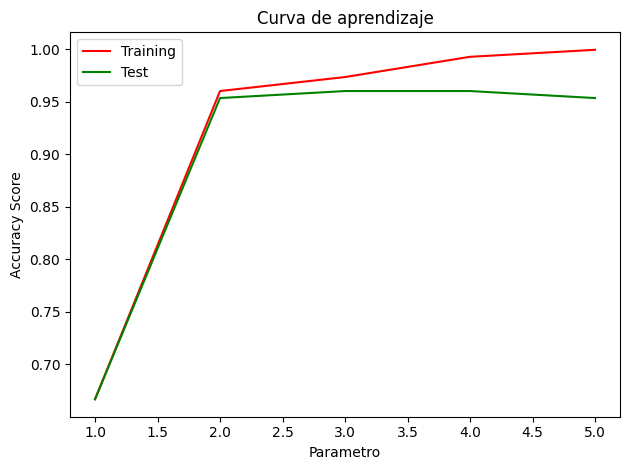

In [27]:
import matplotlib.pyplot as plt

# Draw lines
plt.plot(max_depths, train_accuracy, color="r",  label="Training")
plt.plot(max_depths, test_accuracy, color="g", label="Test")

# Create plot
plt.title("Curva de aprendizaje")
plt.xlabel("Parametro"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()   

## Entrenando el clasificador final

Una vez hemos determinado la mejor combinación de parámetros del clasificador (evitando sobreaprender) y hemos calculado cuál es el rendimiento esperable del modelo (usando datos de validación), podemos entrenar un nuevo modelo con todos los datos y usarlo en "producción" cuando nos lleguen nuevos datos.



In [28]:
# Entrenar clasificador con los mejores parámetros

# Suponemos la siguiente combinación como la mejor (probablemente no es cierto)
clf = DecisionTreeClassifier(criterion="entropy", max_depth=3, min_samples_split=2, random_state=RANDOM_STATE)
clf = clf.fit(iris.data, iris.target)



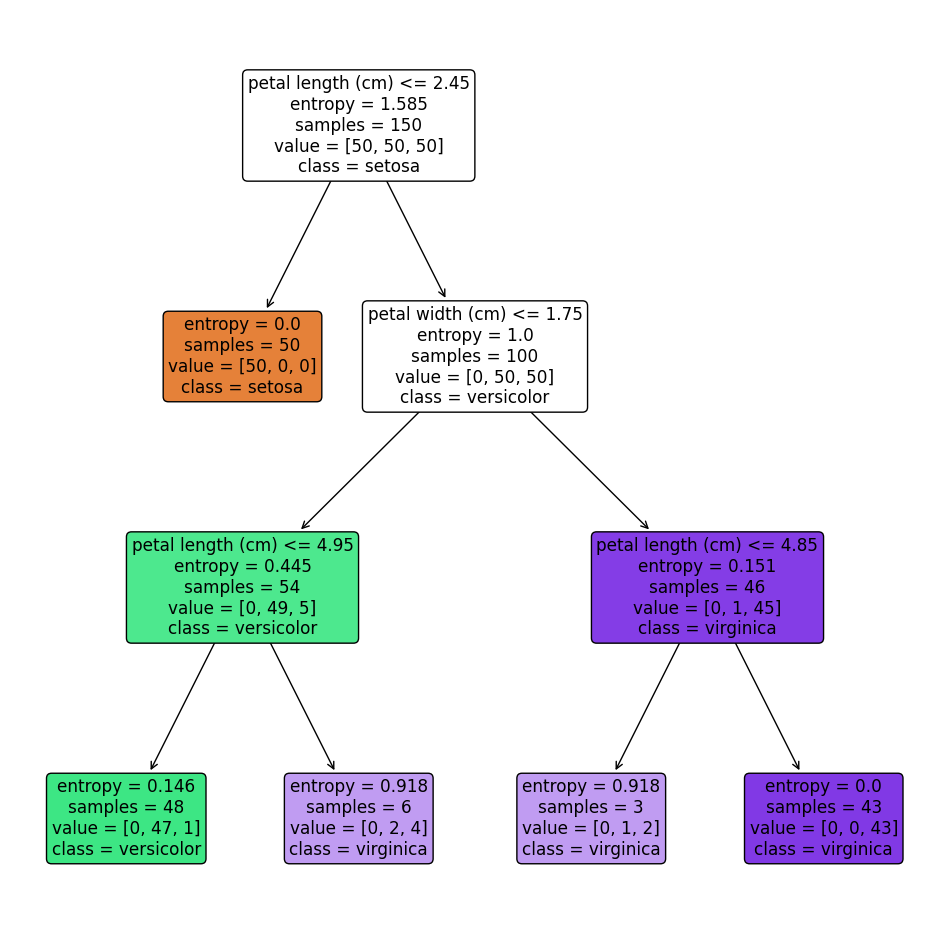

In [29]:
# Tiene que salir algo como esto

# Pintamos el árbol
plt.figure(figsize=(12,12))
plot_tree(clf, filled=True, feature_names=iris['feature_names'], class_names=iris['target_names'], rounded=True)
plt.show()

Podemos observar como nuestro árbol "optimo" tiene hojas no puras que contiene ejemplos de varias clase. En esos casos el clasificador elegirá la clase mayoritaria para hacer la predicción.

En la siguiente celda puedes ver como podríamos usar este clasificador para predecir la clase de un nuevo ejemplo.

In [21]:
# Predecimos el valor de un ejemplo que nunca hemos visto
# podemos pasar un array de nuevos ejemplos y nos devolverá un array de clases
clase = clf.predict([[5, 3, 1, 0.1]])
# Nos da la clase 0 que es setosa
clase[0], iris['target_names'][clase[0]]

(0, 'setosa')

Aunque no es nuestro caso, porque el árbol es pequeño, pero muchas veces cuesta calibrar qué variables juegan un papel importante en el mismo. La importancia de una variable puede medirse como la agregación ponderada de las ganancias de información que ocasionó su uso en el árbol.

Veamos cómo podemos obtener y mostrar dichos valores con sklearn.

Feature: 0, Score: 0.00000
Feature: 1, Score: 0.00000
Feature: 2, Score: 0.68977
Feature: 3, Score: 0.31023


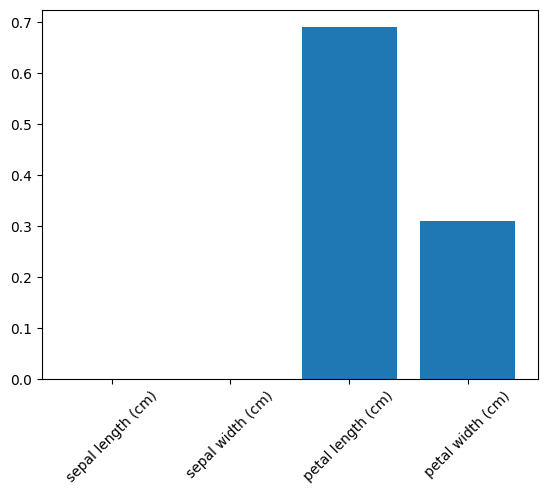

In [22]:
from matplotlib import pyplot as plt

importance = clf.feature_importances_
# summarize feature importance



for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))

# plot feature importance
feature_names=iris['feature_names']
plt.bar([x for x in range(len(importance))], importance, tick_label = feature_names)
plt.xticks(rotation = 45) 
plt.show()